In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

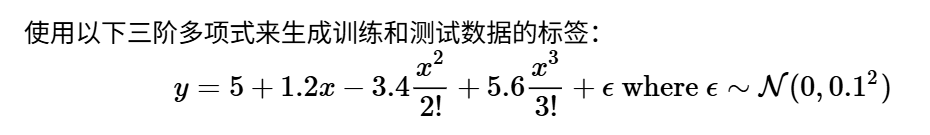

In [3]:
np.zeros(20)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.7440],
         [ 0.3626]]),
 tensor([[ 1.0000e+00, -7.4403e-01,  2.7679e-01, -6.8648e-02,  1.2769e-02,
          -1.9001e-03,  2.3562e-04, -2.5045e-05,  2.3292e-06, -1.9256e-07,
           1.4327e-08, -9.6907e-10,  6.0085e-11, -3.4389e-12,  1.8276e-13,
          -9.0653e-15,  4.2155e-16, -1.8450e-17,  7.6263e-19, -2.9864e-20],
         [ 1.0000e+00,  3.6262e-01,  6.5745e-02,  7.9467e-03,  7.2040e-04,
           5.2246e-05,  3.1575e-06,  1.6357e-07,  7.4140e-09,  2.9871e-10,
           1.0832e-11,  3.5707e-13,  1.0790e-14,  3.0097e-16,  7.7954e-18,
           1.8845e-19,  4.2709e-21,  9.1100e-23,  1.8352e-24,  3.5026e-26]]),
 tensor([2.5950, 5.1317]))

In [4]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9971175  1.174094  -3.3920536  5.648631 ]]


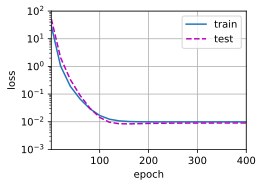

In [6]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[2.712687  4.8009415]]


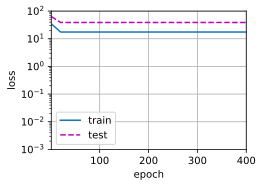

In [7]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 5.0014243e+00  1.2490004e+00 -3.4382527e+00  5.2665505e+00
   5.6741484e-02  1.0402808e+00  6.0297596e-01  1.8393363e-01
   2.0211375e-01 -3.1200226e-03 -2.1853840e-02  1.3763925e-01
  -8.6785063e-02 -2.1875213e-01 -3.1586044e-02 -7.6648325e-02
   1.5142417e-01 -7.4458055e-02  1.7012235e-02  1.5944058e-01]]


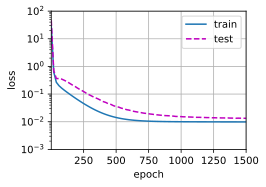

In [8]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)